# Regression of detected intensities

In [12]:
from pathlib import Path
import scipy.stats
from sklearn.metrics import mean_squared_error
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use('dark_background')

plots_dir = Path.cwd() / "../plots"
results_dir = Path.cwd() / "../results/regression_on_detected"


In [13]:
filenames = {
    "all_feat": "results_all_feat.csv",
    "fingerprints_feat": "results_fingerprints_feat.csv",
    "mol_feat": "results_mol_feat.csv",
    "random_feat": "results_random_feat.csv",
    # "no_feat": "regr_results_no_feat.csv",

}

In [14]:
metric = "Spearman's R"

# compute Spearman's/Pearson's correlation and mean squared error for each matrix/polarity/regressor
models_results = pd.DataFrame()
model_metrics = pd.DataFrame(columns = ['regr_type', 'matrix', 'polarity', 'regressor', "Spearman's R",
                                                 'S pval', "Pearson's R", 'P pval', 'RMSE', 'RMSE/std', 'non-zero obs'])
model_performance = pd.DataFrame()
counter = 0

for regr_type in filenames:
    result_filename = filenames[regr_type]
    loc_models_results = pd.read_csv(results_dir / result_filename, index_col = 0)
    loc_models_results = loc_models_results.rename(columns={'Matrix short': 'matrix',
                                                          'Polarity': 'polarity'})


    for (matrix, polarity, regressor), rows in loc_models_results.groupby(['matrix', 'polarity', 'regressor']):
        # remove zero intensity molecules if needed (optional)
        rows = rows[rows['observed_value']!=0]

        spearman = scipy.stats.spearmanr(rows.observed_value, rows.prediction)
        pearson = scipy.stats.pearsonr(rows.observed_value, rows.prediction)
        mse = mean_squared_error(rows.observed_value, rows.prediction, squared = False)
        mse_std = mse / rows['observed_value'].std()
        model_metrics.loc[counter] = [regr_type, matrix, polarity, regressor, spearman[0], spearman[1],
                                           pearson[0], pearson[1], mse, mse_std,
                                           rows[rows['observed_value']!=0].shape[0]]
        counter += 1

    loc_models_results["regr_type"] = regr_type
    models_results = pd.concat([models_results, loc_models_results])

    # FInd best model across matrices:
    loc_model_performance = pd.DataFrame()
    for (matrix, polarity), rows in model_metrics.groupby(['matrix', 'polarity']):
        rows["difference"] = rows[metric] - rows[metric].max()
        loc_model_performance = pd.concat([loc_model_performance, rows[["regressor", "difference"]]])

    loc_model_performance = loc_model_performance.groupby(["regressor"]).sum()
    loc_model_performance["regr_type"] = regr_type
    model_performance = pd.concat([model_performance, loc_model_performance])




Plot performances of different models, with different input features:

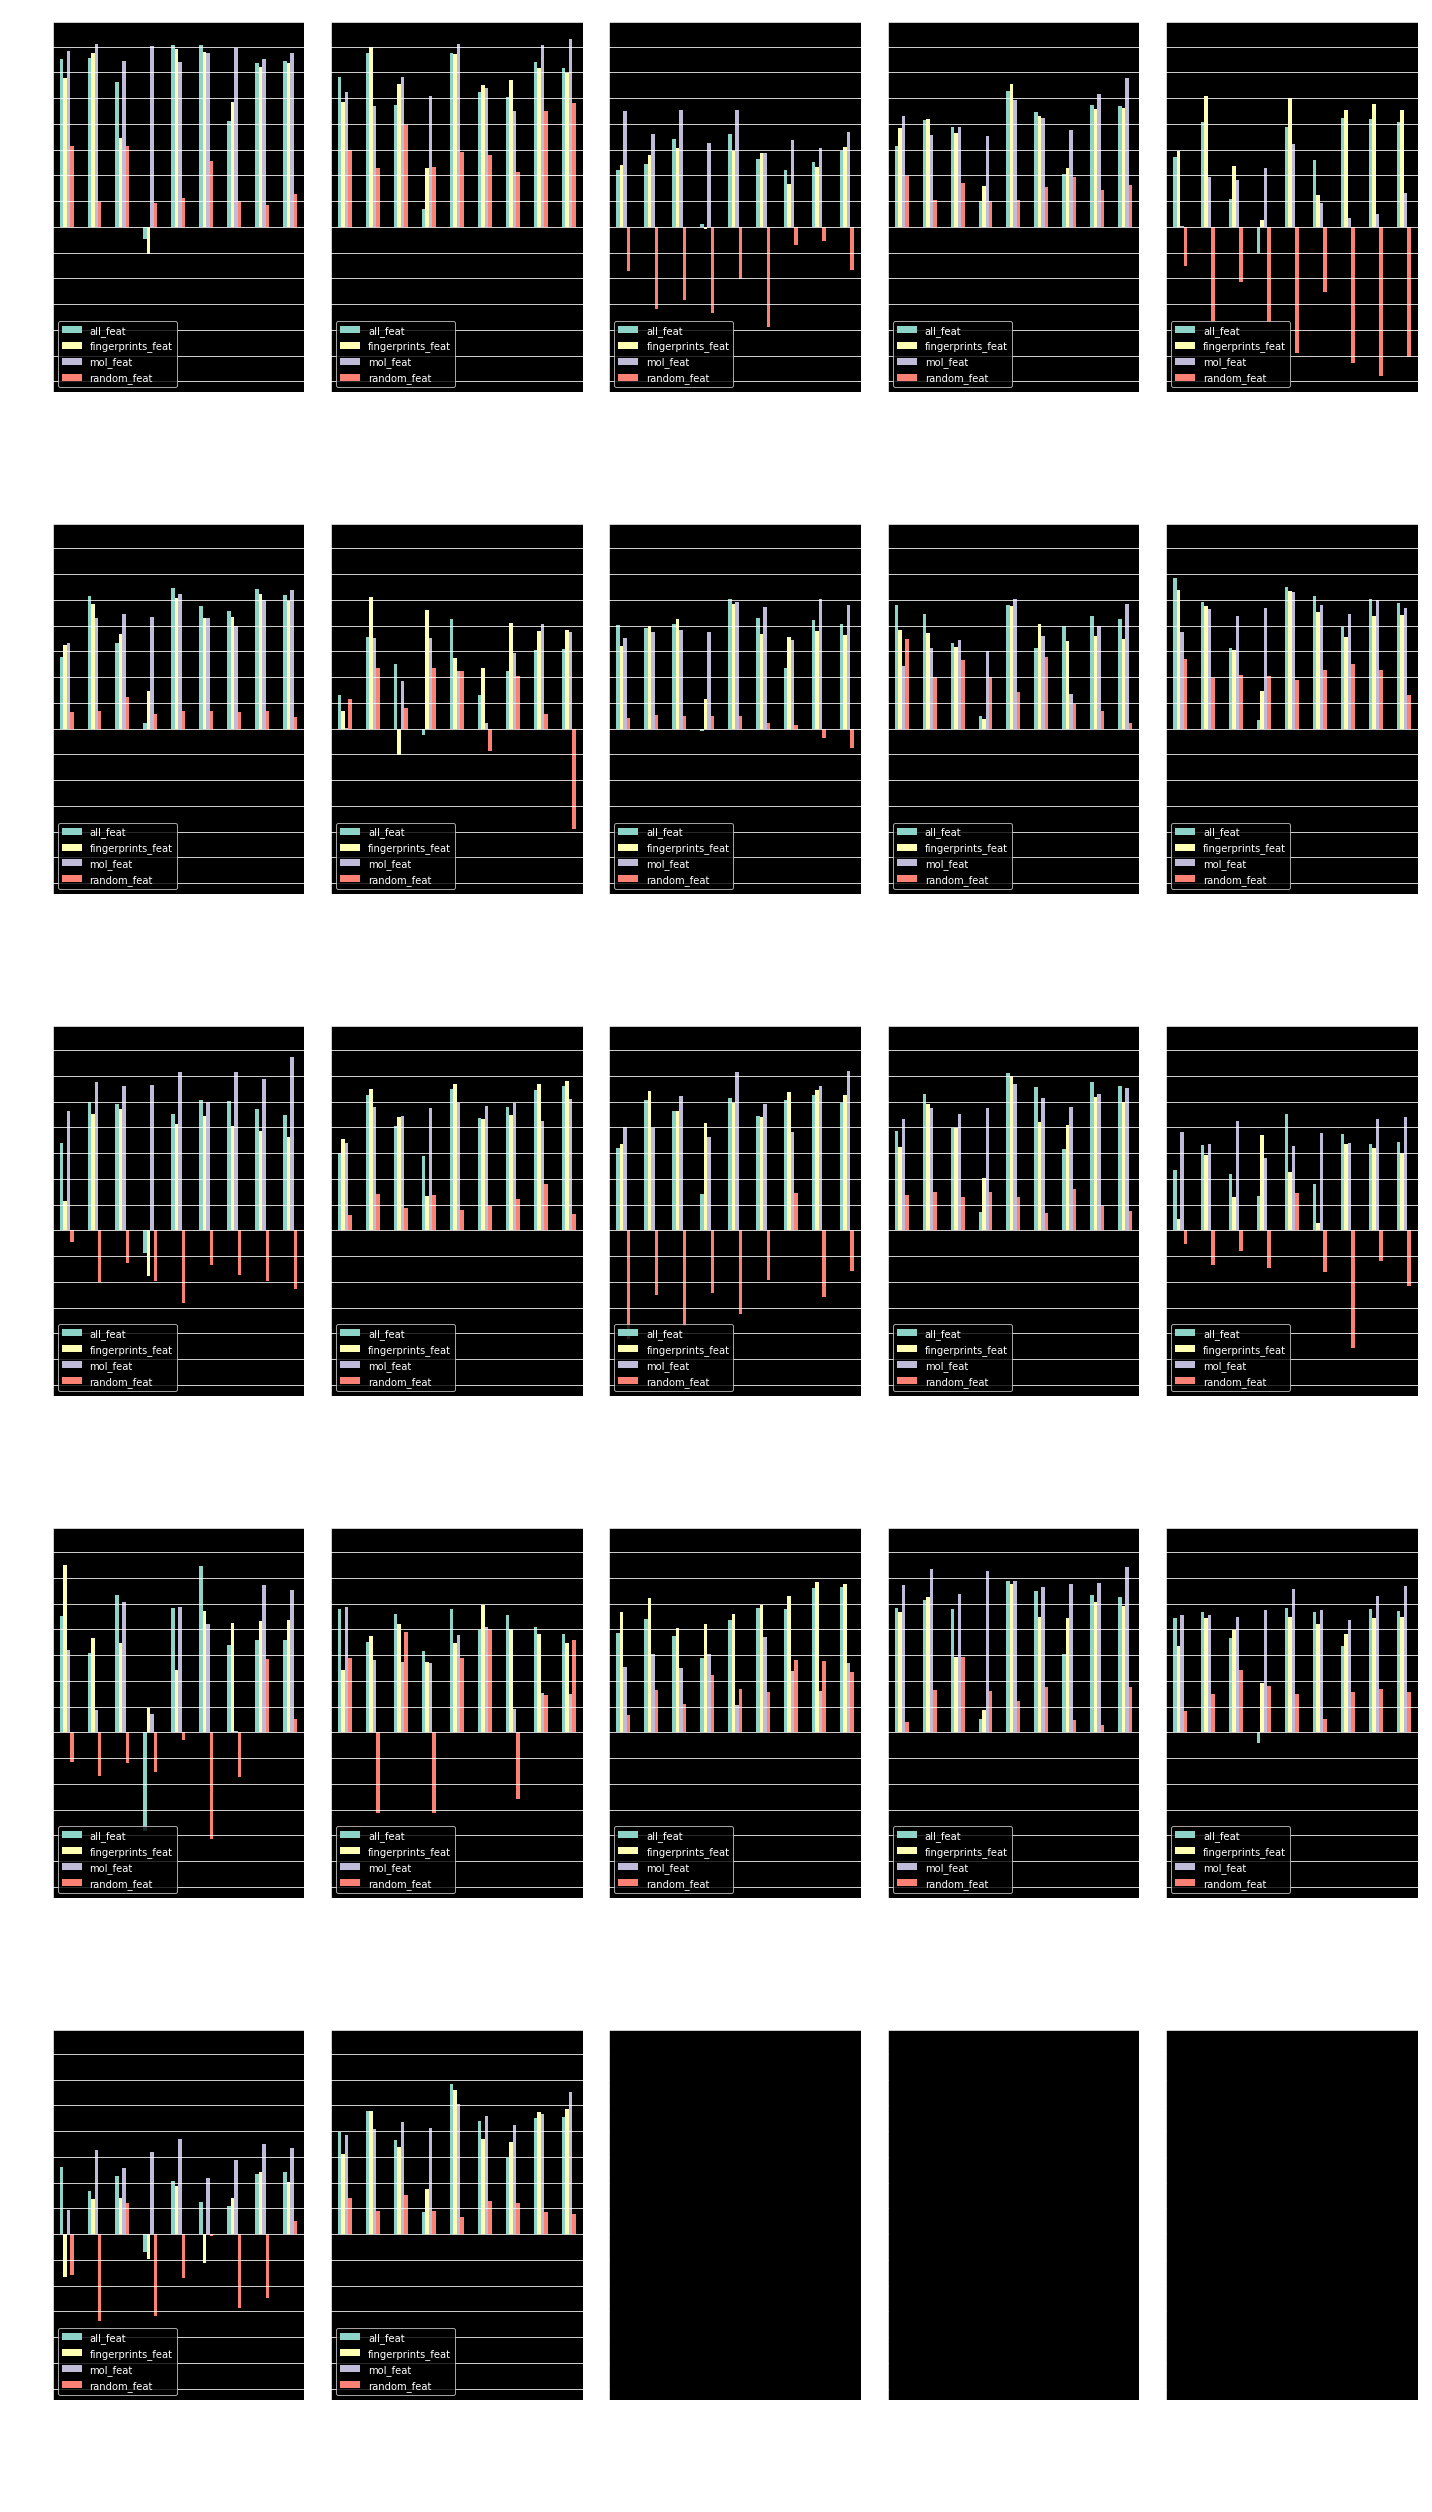

In [20]:
import numpy as np
fig, axes = plt.subplots(ncols=5,nrows=5, sharey=True, figsize= (20, 35))
ax_list = axes.flat

metric = "Spearman's R"
#metric = "RMSE"

i = 0
for (matrix, polarity), rows in model_metrics.groupby(['matrix', 'polarity']):
    nb_obs = rows['non-zero obs'].drop_duplicates().values[0]
    rows = rows.set_index(['regressor', "regr_type"], drop = True).sort_values( by = ["regr_type", metric])
    rows = rows.unstack("regr_type")
    rows[metric].plot.bar(ax = ax_list[i], title=f"{matrix}-{polarity} ({nb_obs})")
    ax_list[i].set_ylabel(metric)
    ax_list[i].grid(axis='y')
    ax_list[i].legend(loc="lower left")
    ax_list[i].set_yticks(np.arange(-0.6, 0.8, 0.1))
    # if i != 0:
    #     ax_list[i].get_legend().set_visible(False)
    i+=1

# plt.subplots_adjust(hspace=0.5)
plt.tight_layout()
plt.show()


For each matrix, get the max "Spearman's R" achieved, and compute difference between this max value and
 the value achieved by each model (compare bars of same colors, not across colors). MLP seems to be the best in all setups:

<AxesSubplot:xlabel='regressor'>

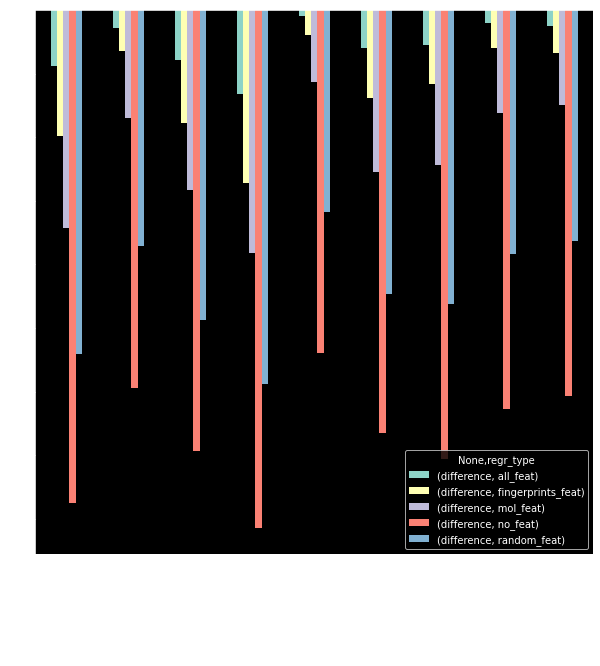

In [80]:
# fig, axes = plt.subplots(ncols=1,nrows=5, figsize= (20, 35))
# ax_list = axes.flat

model_performance.reset_index().sort_values(by="difference").set_index(["regressor", "regr_type"], drop=True).unstack("regr_type").plot.bar(figsize=(10,10))

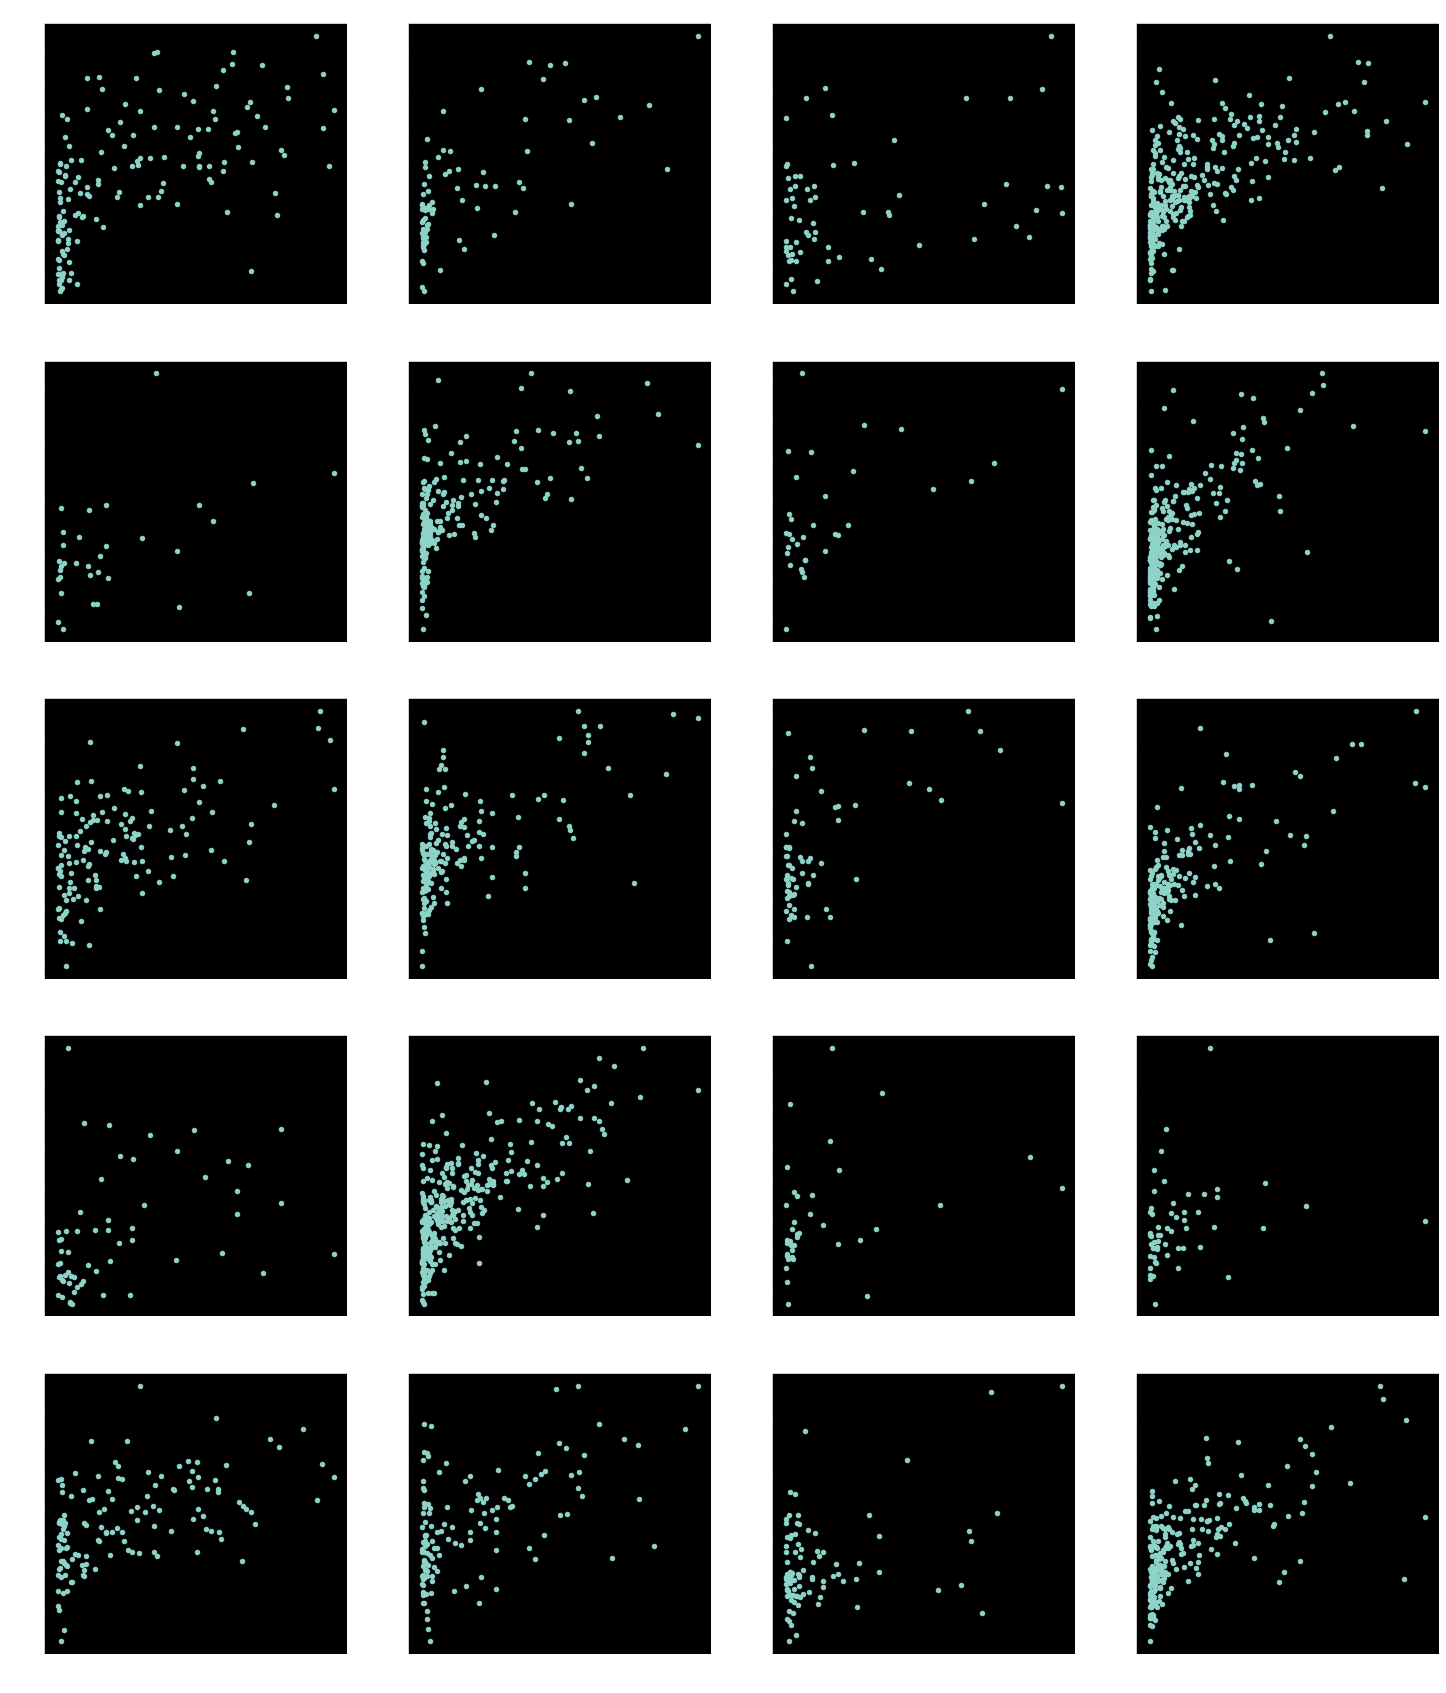

In [67]:
fig, axes = plt.subplots(ncols=4,nrows=5, figsize= (25, 30))
ax_list = axes.flat

regressor = "MLP"
regr_type = "all_feat"

i = 0
for (matrix, polarity), rows in models_results.groupby(['matrix', 'polarity']):
    rows = rows[rows["regr_type"] == regr_type]
    rows[rows.regressor == regressor].plot.scatter(x = 'observed_value', y= 'prediction',
                                                   ax = ax_list[i], title=f"{matrix}-{polarity}-{regressor}")
    i+=1

plt.subplots_adjust(hspace=0.2, wspace=0.2)
plt.show()